In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
path = '/Users/barganor/Downloads/XY_train (1).csv'

data = pd.read_csv(path)
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,13163,city_16,0.910,NaN,No relevent experience,no_enrollment,High School,NaN,2,NaN,NaN,never,16,1
1,9357,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,6,1000-4999,Pvt Ltd,1,262,0
2,604,city_16,0.910,Male,No relevent experience,NaN,NaN,NaN,3,NaN,NaN,never,24,0
3,19033,city_16,0.910,Male,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,1,35,0
4,4825,city_145,0.555,Male,Has relevent experience,Full time course,Graduate,STEM,4,NaN,NaN,1,43,1


### Cities

<AxesSubplot:>

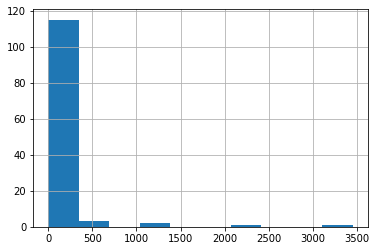

In [2]:
cities_count = data['city'].value_counts()
cities_count.hist()

### Cities development

<AxesSubplot:ylabel='Density'>

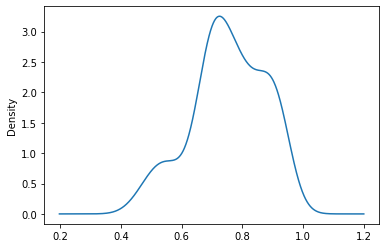

In [3]:
data.groupby('city')['city_development_index'].mean().plot.density()

### Gender

<AxesSubplot:ylabel='gender'>

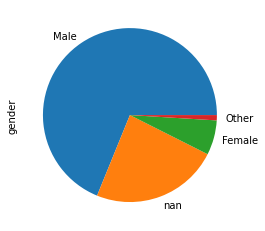

In [4]:
data['gender'].value_counts(dropna=False).plot.pie()

### Relevant experience

<AxesSubplot:>

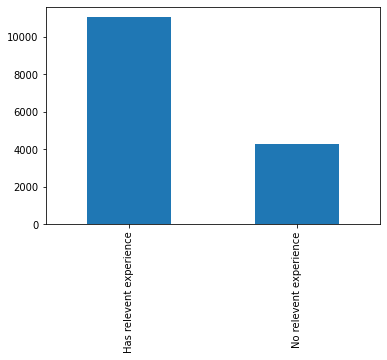

In [5]:
data['relevent_experience'].value_counts().plot(kind='bar')

<AxesSubplot:>

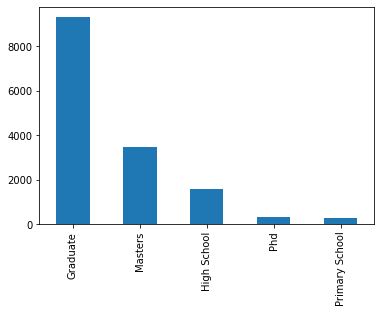

In [6]:
data['education_level'].value_counts().plot(kind='bar')

<AxesSubplot:>

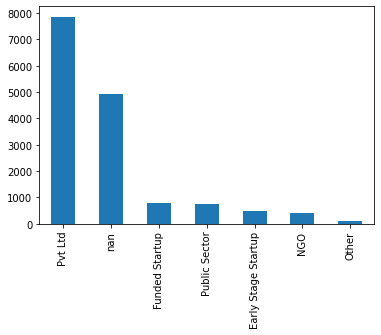

In [7]:
data['company_type'].value_counts(dropna=False).plot(kind='bar')

<AxesSubplot:xlabel='training_hours', ylabel='Density'>

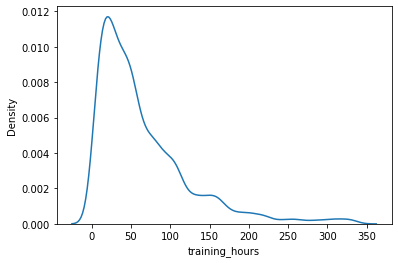

In [8]:
sns.kdeplot(data['training_hours'])

In [9]:
statistical_description = data.describe().transpose()
statistical_description['value_range'] = statistical_description['min'].astype(str) + ' - ' + statistical_description['max'].astype(str)
statistical_description = statistical_description.drop(columns=['count', 'min','max','25%','75%'])
statistical_description

,mean,std,50%,value_range
enrollee_id,16887.713167,9612.278744,17013.500,1.0 - 33380.0
city_development_index,0.829063,0.123161,0.903,0.448 - 0.949
training_hours,65.337466,60.007145,47.000,1.0 - 336.0
target,0.249576,0.432782,0.000,0.0 - 1.0


<AxesSubplot:>

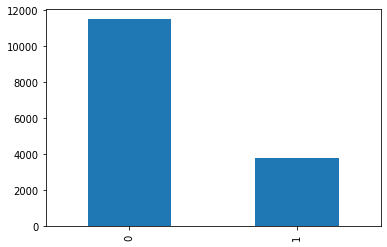

In [10]:
data['target'].value_counts().plot.bar()

In [11]:
print('אחוז מחפשי העבודה לפי מגדר')
data[data['target']==0]['gender'].value_counts() / data['gender'].value_counts()

אחוז מחפשי העבודה לפי מגדר


Male      0.772701
Female    0.739615
Other     0.726667
Name: gender, dtype: float64

In [12]:
median_city_development = data.groupby('city')['city_development_index'].mean().describe()['50%']
job_seekers_in_good_cities = data[(data['city_development_index']>median_city_development) & (data['target'] == 0)]['target'].count()/ data['target'].count()
job_seekers_in_bad_cities = data[(data['city_development_index']<median_city_development) & (data['target'] == 0)]['target'].count()/ data['target'].count()

pd.DataFrame({'Looking for a job highly developed cities': job_seekers_in_good_cities, 'Looking for a job un-developed cities': job_seekers_in_bad_cities},index=['Percentage'])

,Looking for a job highly developed cities,Looking for a job un-developed cities
Percentage,0.617774,0.13265


# Pre Processing

In [13]:
# Make copy of original data
processed_data = data.copy()

In [14]:
# Check for duplicated data
print(processed_data.shape)
print(processed_data.drop_duplicates().shape)

(15326, 14)
(15326, 14)


In [15]:
# Dealing with missing values
processed_data.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    3639
relevent_experience          0
enrolled_university        311
education_level            370
major_discipline          2237
experience                  48
company_size              4779
company_type              4943
last_new_job               332
training_hours               0
target                       0
dtype: int64

In [16]:
# Transform experience to floats and fill nan with the median.
replacement_dct = {'>20':'25','<1':'0'}
processed_data['experience'] = processed_data['experience'].replace(replacement_dct).astype('float64')

# Calculate median
exp_median = np.median(processed_data['experience'].dropna().values)

# Change nan values to calculated median
processed_data['experience'] = processed_data['experience'].fillna(exp_median)

In [17]:
processed_data = processed_data.dropna(thresh=12, axis=0)

In [18]:
processed_data.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    2278
relevent_experience          0
enrolled_university        106
education_level             56
major_discipline           845
experience                   0
company_size              2629
company_type              2773
last_new_job               117
training_hours               0
target                       0
dtype: int64

In [19]:
size_replacement_dict = {
                        '50-99':3,
                        '100-500':4,
                        '10000+':8,
                        'Oct-49':2,
                        '1000-4999':6,
                        '<10':1,
                        '500-999':5,
                        '5000-9999':7
                        }

processed_data['company_size'] = processed_data['company_size'].replace(size_replacement_dict)

In [20]:
processed_data.shape

(13046, 14)

In [27]:
processed_data.dropna(thresh=13, axis=0).isna().sum()

,company_size,company_type
1,6.0,Pvt Ltd
4,NaN,NaN
5,5.0,Pvt Ltd
6,1.0,Pvt Ltd
7,3.0,Pvt Ltd
...,...,...
15317,8.0,Pvt Ltd
15318,8.0,Pvt Ltd
15320,8.0,Pvt Ltd
15323,2.0,Early Stage Startup


In [23]:
# Code that shoes that "company_size" is not important for forecasting
pd.DataFrame({'size':processed_data['company_size'].values, 'target': processed_data['target']}).groupby('size').sum() / pd.DataFrame({'size':processed_data['company_size'].values, 'target': processed_data['target']}).groupby('size').count()

,target
size,
1.0,0.165531
2.0,0.243533
3.0,0.174486
4.0,0.162135
5.0,0.171470
6.0,0.154280
7.0,0.180617
8.0,0.189408
